In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer    # Tensorflow un Tokenizer fonksiyonu
from tensorflow.keras.preprocessing.sequence import pad_sequences    # modele vereceğimiz squence lerin aynı boyutta olmasını sağlıyor.

In [2]:
df = pd.read_csv("tweet_data.csv")
df.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweetID     785916 non-null  int64 
 1   crDate      785916 non-null  object
 2   edInput     785916 non-null  int64 
 3   editor      785916 non-null  int64 
 4   engages     785916 non-null  int64 
 5   isApproved  785916 non-null  bool  
 6   isEdNeed    785916 non-null  bool  
 7   isRT        785916 non-null  bool  
 8   likes       785916 non-null  int64 
 9   photoUrl    277896 non-null  object
 10  retweets    785916 non-null  int64 
 11  rtUsID      785916 non-null  int64 
 12  text        785916 non-null  object
 13  topicName   785916 non-null  object
 14  usFlwrs     785916 non-null  int64 
 15  usID        785916 non-null  int64 
 16  usName      785916 non-null  object
 17  videoUrl    140491 non-null  object
dtypes: bool(3), int64(9), object(6)
memory usage: 92.2+ MB


In [4]:
df = df[(df["edInput"] != -1) & (df["edInput"] != 3)]

In [5]:
df['edInput'] = df['edInput'].replace(4, 1)

In [6]:
unique_values = df['edInput'].unique()
print(unique_values)

[1 2]


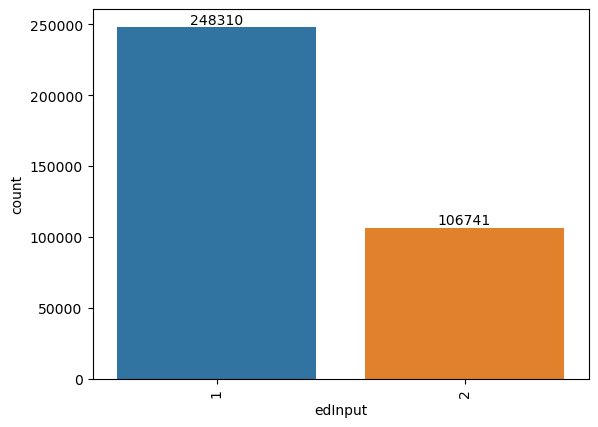

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.countplot(data =df, x ="edInput")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =90);

In [9]:
df["edInput"].value_counts()

1    248310
2    106741
Name: edInput, dtype: int64

In [10]:
pd.Series(df.edInput).value_counts(normalize=True)

1    0.699364
2    0.300636
Name: edInput, dtype: float64

In [11]:
df2 = df.copy()

In [12]:
df2["text"].head()

721     Which one would you choose? 👀 https://t.co/U0s...
1374             How it’s made. 😊 https://t.co/3XjOw4gIkg
1867    Smile, because it confuses people. Smile, beca...
2206                 𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw
2263    Baby Alpacas are so under appreciated. https:/...
Name: text, dtype: object

In [13]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import warnings

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stop_words = stopwords.words('english')

In [17]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def cleaning(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()
    data = re.sub(r'^https?:\/\/.*[\r\n]*', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")    #don't gibi ifadeleri ' dan kurtarmış oluyoruz.
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [18]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [100]:
dfx = df2["text"].apply(cleaning)       #cleaning fonksiyonumu apply ile tüm text ime uyguluyorum
dfx.head(19)

721                                      one would choose
1374                                                 made
1867    smile confuses people smile easier explaining ...
2206                                         𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡
2263                              baby alpaca appreciated
2389                         felt cute might delete later
2583                                    sunflower pendant
2619                                             need one
2660    people idea compassion entail complete disrega...
2779                               big hop energy bferber
2829                                         jeopardy lit
3683                                       could say face
3952                                     whiskeyretriever
4213                          aroma restaurant rome italy
4414    faa sai rescue elephant naughty broke sprinkle...
4507                         pulling love affection offer
4743                           burrito kimcheethemaltipoo
5395          

In [143]:
dfx =df2[["edInput", "text"]]
dfx.head(19)

,edInput,text
721,1,one would choose
1374,1,made
1867,2,smile confuses people smile easier explaining ...
2206,1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡
2263,1,baby alpaca appreciated
2389,2,felt cute might delete later
2583,2,sunflower pendant
2619,2,need one
2660,1,people idea compassion entail complete disrega...
2779,1,big hop energy bferber


In [144]:
X = df2['text'].values    # Deep Learning de datayı arraya çevirmek için .values ekliyoruz.
y = df2['edInput'].values

In [145]:
num_words = 15000 # corpusta geçen en fazla kullanılan ilk 15.000 kelimeyi(tokeni) alacağız gerisini yok sayacağız. 
# None değeri atanırsa tüm kelimeler dikkate alınır.
tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890' 

In [146]:
tokenizer.fit_on_texts(X)     # Tensorflow un kendisinin geliştirdiği Tokenizer fonksiyonu... #otomatik olarak lower yapıyor.

In [147]:
tokenizer.word_index

{'new': 1,
 'one': 2,
 'get': 3,
 'life': 4,
 'people': 5,
 'day': 6,
 'time': 7,
 'make': 8,
 'year': 9,
 'like': 10,
 'say': 11,
 'trump': 12,
 'world': 13,
 'u': 14,
 'want': 15,
 'first': 16,
 'today': 17,
 'see': 18,
 'work': 19,
 'thing': 20,
 'dont': 21,
 'love': 22,
 'look': 23,
 'need': 24,
 'take': 25,
 'photo': 26,
 'way': 27,
 'best': 28,
 'via': 29,
 'good': 30,
 'go': 31,
 'know': 32,
 'art': 33,
 'president': 34,
 'back': 35,
 'could': 36,
 'week': 37,
 'never': 38,
 'artist': 39,
 'house': 40,
 'would': 41,
 'woman': 42,
 'show': 43,
 'think': 44,
 'right': 45,
 'live': 46,
 'last': 47,
 'help': 48,
 'may': 49,
 'change': 50,
 'let': 51,
 'find': 52,
 'video': 53,
 'design': 54,
 'every': 55,
 'said': 56,
 'made': 57,
 'come': 58,
 'great': 59,
 'home': 60,
 'million': 61,
 'read': 62,
 'btc': 63,
 'someone': 64,
 'going': 65,
 'still': 66,
 'two': 67,
 'around': 68,
 'give': 69,
 'next': 70,
 'space': 71,
 'city': 72,
 'watch': 73,
 'cc': 74,
 'much': 75,
 'even': 76,


In [148]:
len(tokenizer.word_index)   #  ilk 15.000 ini eğitimde modele sokacağız. 

81616

In [149]:
X_num_tokens = tokenizer.texts_to_sequences(X)   # TEXT IMI TOKENIZE IŞLEMİNE TABİ TUT.

In [150]:
X_num_tokens[105]

[12111,
 2374,
 34,
 324,
 12,
 16,
 1139,
 4286,
 12,
 244,
 796,
 2787,
 330,
 2374,
 636,
 1569,
 1409,
 121,
 40,
 870,
 330,
 121,
 40,
 26,
 5844,
 7416]

In [151]:
dfx.head(11)

,edInput,text
721,1,one would choose
1374,1,made
1867,2,smile confuses people smile easier explaining ...
2206,1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡
2263,1,baby alpaca appreciated
2389,2,felt cute might delete later
2583,2,sunflower pendant
2619,2,need one
2660,1,people idea compassion entail complete disrega...
2779,1,big hop energy bferber


In [152]:
num_tokens = [len(tokens) for tokens in X_num_tokens] # X_num_tokens deki (yorumlardaki) her bir tokeni al ve say...
num_tokens = np.array(num_tokens)   # mean, max etc gibi işlemleri daha rahat yapabilmek için array a çevirdik.

In [153]:
num_tokens

array([ 3,  1,  7, ...,  3, 12,  6])

In [154]:
num_tokens.mean()

8.490439401663423

In [155]:
num_tokens.max()

41

In [156]:
num_tokens.argmax() # listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

41134

In [157]:
X_num_tokens[41134]

[1522,
 785,
 18,
 63,
 5475,
 21,
 44,
 485,
 6007,
 1893,
 1522,
 785,
 18,
 63,
 5475,
 257,
 485,
 21,
 15,
 18,
 63,
 5475,
 257,
 3768,
 485,
 6007,
 21,
 15,
 18,
 63,
 5475,
 257,
 606,
 378,
 552,
 41,
 5082,
 1385,
 2527,
 4182,
 730]

In [158]:
len(X_num_tokens[41134])

41

In [159]:
max_tokens = 65  # Maksimum belirlemek istediğiniz belirli bir değeri kullanabilirsiniz
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)


In [117]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)   # sabitleme 

In [118]:
X_pad.shape

(355051, 65)

In [119]:
np.array(X_num_tokens[400])

array([  427,  2536,   389,   334,   605,   164, 10110,   573,   449,
          69,   423,   154,  1245, 10108])

In [120]:
X_pad[400]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,   427,  2536,   389,
         334,   605,   164, 10110,   573,   449,    69,   423,   154,
        1245, 10108])

In [121]:
np.array(X_num_tokens[232976])

array([5923,  865,    3, 2368])

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=0)

In [124]:
model = Sequential()

In [125]:
embedding_size = 50   # EMBEDDING SIZE İLE OYNAYARAK OVERFITTING E ENGEL OLABİLİRİZ.

In [126]:
!pip install -U numpy==1.19.5 

  Using cached numpy-1.19.5.zip (7.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [202 lines of output]
  setup.py:67: RuntimeWarning: NumPy 1.19.5 may not yet support Python 3.10.
    warnings.warn(
  Running from numpy source directory.
  setup.py:480: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
    run_build = parse_setuppy_commands()
  Processing numpy/random\_bounded_integers.pxd.in
  Processing numpy/random\bit_generator.pyx
  Processing numpy/random\mtrand.pyx
  Processing numpy/random\_bounded_integers.pyx.in
  Processing numpy/random\_common.pyx
  Processing numpy/random\_generator.pyx
  Processing numpy/random\_mt19937.pyx
  Processing numpy/random\_pcg64.pyx
  Processing numpy/random\_philox.pyx
  Processing numpy/random\_sfc64.pyx
  Cythonizing sources
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying fro

In [127]:
model.add(Embedding(input_dim=num_words,   # İLK 15.000 TOKENI AL..
                    output_dim=embedding_size,    # KAÇ BOYUTTA OLACAĞINI İFADE EDİYOR (50 BOYUT)
                    input_length=max_tokens))   # HER BİR YORUMUN UZUNLUĞU (61 TOKEN)

model.add(Dropout(0.2))   # 50 BOYUTLU VEKTÖRÜN YÜZDE 20 SİNE KADAR KAPATIR..

model.add(GRU(units=48, return_sequences=True))    # LSTM DE KULLANILABİLİR..    UNITS= VEKTÖRÜ 48 BOYUTA DÜŞÜRÜR 
model.add(Dropout(0.2))         # RETURN SEQUENCE= TRUE OLDUĞU ZAMAN... BİR SONRAKİ HIDDEN LAYER A GÖNDERİLEN BİLGİLER TOPLU OLARAK AKTARILIR..  

#model.add(GRU(units=24, return_sequences=True))
#model.add(Dropout(0.2))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))

In [128]:
optimizer = Adam(learning_rate=0.01)    # OVERFITTING İÇİN DEĞİŞİKLİK YAPABİLİRİZ.

In [129]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

In [130]:
model.summary() 
# 3 x (n2 + nm + 2n) m= input, n= output
# (48*48 + 100*48 +2*48)*3 ==> m = 50, n = 48
# (24*24 + 48*24  +2*24)*3 ==> m =  48, n = 24
# (12*12 + 24*12  +2*12)*3 ==> m =  24, n = 12

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 65, 50)            750000    
                                                                 
 dropout_4 (Dropout)         (None, 65, 50)            0         
                                                                 
 gru_4 (GRU)                 (None, 65, 48)            14400     
                                                                 
 dropout_5 (Dropout)         (None, 65, 48)            0         
                                                                 
 gru_5 (GRU)                 (None, 12)                2232      
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 766,645
Trainable params: 766,645
Non-tr

In [131]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max",   #mode= auto da trendi takip eder.             
                           verbose=1, patience = 2, restore_best_weights=True)

In [132]:
from sklearn.utils import class_weight     # DENGESİZ BİR DATA OLDUĞU İÇİN YENİ BİR AĞIRLANDIRMA YAPILIYOR.
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pd.Series(classes_weights).unique()

array([1.66313398, 0.71493655])

In [133]:
model.fit(X_train, y_train, epochs=10, batch_size=256, sample_weight= classes_weights,
         validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
1110/1110 [==============================] - 170s 150ms/step - loss: -38.3037 - recall: 0.9997 - val_loss: -44.6980 - val_recall: 1.0000
Epoch 2/10
1110/1110 [==============================] - 165s 149ms/step - loss: -110.2486 - recall: 1.0000 - val_loss: -87.9268 - val_recall: 1.0000
Epoch 3/10
1110/1110 [==============================] - 187s 169ms/step - loss: -182.0948 - recall: 1.0000 - val_loss: -131.0911 - val_recall: 1.0000
Epoch 3: early stopping


In [134]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,-38.303745,0.999676,-44.698013,1.0
1,-110.248558,1.000000,-87.926796,1.0
2,-182.094849,1.000000,-131.091141,1.0


<Axes: >

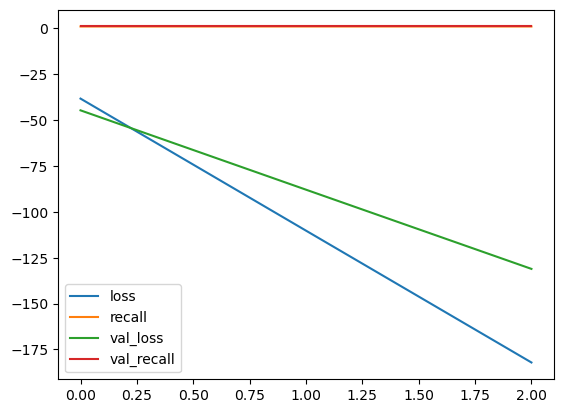

In [135]:
model_loss.plot()

In [136]:
model.evaluate(X_train, y_train)

8877/8877 [==============================] - 236s 27ms/step - loss: -44.6983 - recall: 1.0000


[-44.69827651977539, 1.0]

In [137]:
model.evaluate(X_test, y_test)

2220/2220 [==============================] - 60s 27ms/step - loss: -44.6982 - recall: 1.0000


[-44.69819259643555, 1.0]

In [138]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

8877/8877 [==============================] - 231s 26ms/step
[[198647      0]
 [ 85393      0]]
-------------------------------------------------------


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.70      1.00      0.82    198647
           2       0.00      0.00      0.00     85393

    accuracy                           0.70    284040
   macro avg       0.35      0.50      0.41    284040
weighted avg       0.49      0.70      0.58    284040



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [139]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

2220/2220 [==============================] - 49s 22ms/step
[[49663     0]
 [21348     0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.70      1.00      0.82     49663
           2       0.00      0.00      0.00     21348

    accuracy                           0.70     71011
   macro avg       0.35      0.50      0.41     71011
weighted avg       0.49      0.70      0.58     71011



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2220/2220 [==============================] - 55s 25ms/step


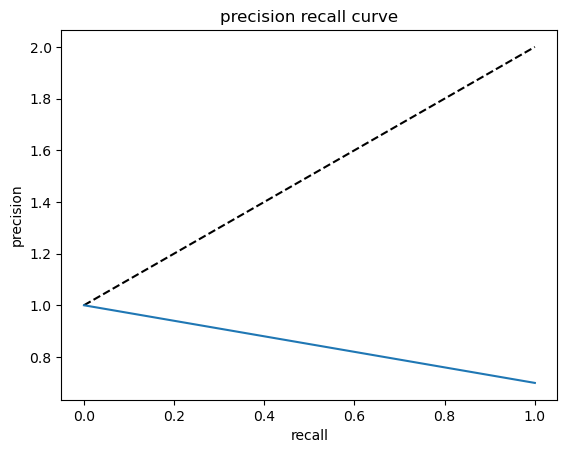

In [140]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label=1)

y_pred_proba = model.predict(X_test)

plt.plot([1,2],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [141]:
average_precision_score(y_test, y_pred_proba)

0.6993705200602723